<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/test/pytorch_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
VERSION = "nightly" #@param ["20200220","nightly", "xrt==1.15.0"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  50156      0 --:--:-- --:--:-- --:--:-- 50156
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
     |████████████████████████████████| 61kB 3.0MB/s 
Uninstalling torch-1.7.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling torchvision-0.8.1+cu101:
Done updating TPU runtime
  Successfully uninstalled torchvision-0.8.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
\ [1 files][ 94.3 MiB/ 94.3 MiB]                                                
Operation completed over 1 objects/94.3 MiB.                                     
Copying gs://

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 77kB/s 
  Found existing installation: torch-xla 1.6+ee12b88
    Uninstalling torch-xla-1.6+ee12b88:
      Successfully uninstalled torch-xla-1.6+ee12b88


In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
# Create a random tensor on xla:1 
dev = xm.xla_device()
t1 = torch.ones(3, 3, device=dev)
print(t1)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='xla:1')


In [ ]:
second_dev = xm.xla_device(n = 2, devkind='TPU')
t2 = torch.zeros(3, 3, device=second_dev)
print(t2)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='xla:2')


In [ ]:
a = torch.randn(2, 2, device=dev)
b = torch.randn(2, 2, device=dev)
print(a + b)
print(b * 2)
print(torch.matmul(a, b))

tensor([[-0.3088,  0.6661],
        [ 1.3402, -0.4989]], device='xla:1')
tensor([[-1.2814,  3.1716],
        [ 2.1050, -2.6671]], device='xla:1')
tensor([[-1.1809,  1.7529],
        [ 0.6977, -0.6614]], device='xla:1')


In [ ]:
filters = torch.randn(33, 16, 3, device=dev)
inputs = torch.randn(20, 16, 50, device=dev)
torch.nn.functional.conv1d(inputs, filters)

tensor([[[ 4.6650e+00,  2.4131e+00,  8.4184e+00,  ..., -3.4691e+00,
           1.3903e+00, -1.0927e+00],
         [ 3.4179e+00,  8.0244e+00, -9.9459e+00,  ..., -8.1479e+00,
          -3.1750e+00,  4.1194e+00],
         [ 1.3079e+01,  4.3412e-01,  4.8352e+00,  ..., -5.5864e+00,
          -5.9210e+00,  3.0204e+00],
         ...,
         [-9.0025e-01,  1.0062e+00, -7.9940e+00,  ..., -3.3179e-01,
           1.4145e+00, -1.6179e+00],
         [ 6.8360e+00, -7.3494e+00, -5.3362e+00,  ..., -2.9572e+00,
          -2.2959e-02,  3.9403e+00],
         [ 5.0153e+00,  8.0487e+00,  1.1326e+01,  ..., -1.4361e+00,
          -3.4222e+00, -1.2024e+01]],

        [[ 7.2372e+00,  4.9307e+00, -3.2422e-02,  ..., -1.2313e+00,
          -7.7229e+00, -2.7538e-01],
         [ 1.3342e+00, -3.3721e+00, -3.7326e+00,  ...,  1.9647e+00,
           2.9404e+00, -2.5306e+00],
         [-1.4254e+00, -1.2025e+01, -8.0462e+00,  ..., -9.1502e+00,
          -4.7130e+00, -8.2591e+00],
         ...,
         [ 1.4655e-01,  2

In [ ]:
t_cpu = torch.rand(2, 2, device='cpu')
print(t_cpu)
t_tpu = t_cpu.to(dev)
print(t_tpu)
t_cpu_again = t_tpu.to('cpu')
print(t_cpu_again)

tensor([[0.7431, 0.7050],
        [0.8456, 0.2437]])
tensor([[0.7431, 0.7050],
        [0.8456, 0.2437]], device='xla:1')
tensor([[0.7431, 0.7050],
        [0.8456, 0.2437]])


In [ ]:
fc = torch.nn.Linear(5, 2, bias=True)
fc = fc.to(dev)
features = torch.rand(3, 5, device=dev, requires_grad=True)
output = fc(features)
print(output)

tensor([[-0.1844,  0.2907],
        [-0.3993,  0.2969],
        [-0.0952,  0.4496]], device='xla:1', grad_fn=<AddmmBackward>)


In [ ]:
output.backward(torch.ones_like(output))
print(fc.weight.grad)

tensor([[0.7920, 1.6270, 1.3105, 1.3555, 0.8315],
        [0.7920, 1.6270, 1.3105, 1.3555, 0.8315]], device='xla:1')


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Simple example network from 
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Places network on the default TPU core
net = Net().to(dev)

# Creates random input on the default TPU core
input = torch.randn(1, 1, 32, 32, device=dev)

# Runs network
out = net(input)
print(out)

tensor([[ 0.1949, -0.0153, -0.0022,  0.0143, -0.1247,  0.0424, -0.1731, -0.0325,
          0.0929,  0.0782]], device='xla:1', grad_fn=<AddmmBackward>)


In [18]:
import numpy as np

In [19]:
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.rand(100, 1)

In [21]:
idx = np.arange(100)
np.random.shuffle(idx)

In [22]:
train_idx = idx[:80]
val_idx = idx[80:]

In [23]:
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [24]:
import matplotlib.pyplot as plt

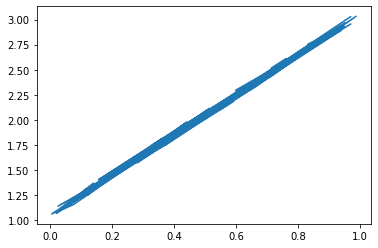

In [28]:
plt.plot(x_train, y_train)

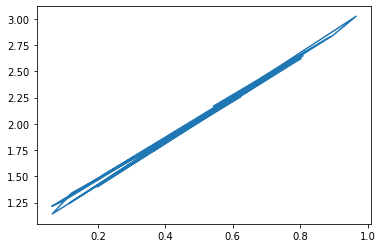

In [29]:
plt.plot(x_val, y_val)

## Linear Regression

y = a + bx + e; a = 1, b = 2

In [33]:
np.random.seed(1234)

x = np.random.rand(100, 1)
print(x)
y = 1 + 2 * x + 0.1 * np.random.randn(100, 1)

idx = np.arange(100)
np.random.shuffle(idx)
print(idx)

train_idx = idx[:80]
val_idx = idx[80:]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

[[0.19151945]
 [0.62210877]
 [0.43772774]
 [0.78535858]
 [0.77997581]
 [0.27259261]
 [0.27646426]
 [0.80187218]
 [0.95813935]
 [0.87593263]
 [0.35781727]
 [0.50099513]
 [0.68346294]
 [0.71270203]
 [0.37025075]
 [0.56119619]
 [0.50308317]
 [0.01376845]
 [0.77282662]
 [0.88264119]
 [0.36488598]
 [0.61539618]
 [0.07538124]
 [0.36882401]
 [0.9331401 ]
 [0.65137814]
 [0.39720258]
 [0.78873014]
 [0.31683612]
 [0.56809865]
 [0.86912739]
 [0.43617342]
 [0.80214764]
 [0.14376682]
 [0.70426097]
 [0.70458131]
 [0.21879211]
 [0.92486763]
 [0.44214076]
 [0.90931596]
 [0.05980922]
 [0.18428708]
 [0.04735528]
 [0.67488094]
 [0.59462478]
 [0.53331016]
 [0.04332406]
 [0.56143308]
 [0.32966845]
 [0.50296683]
 [0.11189432]
 [0.60719371]
 [0.56594464]
 [0.00676406]
 [0.61744171]
 [0.91212289]
 [0.79052413]
 [0.99208147]
 [0.95880176]
 [0.79196414]
 [0.28525096]
 [0.62491671]
 [0.4780938 ]
 [0.19567518]
 [0.38231745]
 [0.05387369]
 [0.45164841]
 [0.98200474]
 [0.1239427 ]
 [0.1193809 ]
 [0.73852306]
 [0.58

Text(0, 0.5, 'y')

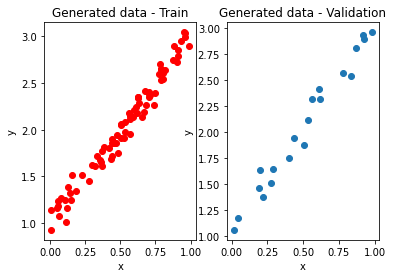

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, color='red')
plt.title('Generated data - Train')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter(x_val, y_val)
plt.title('Generated data - Validation')
plt.xlabel('x')
plt.ylabel('y')

In [39]:
a = np.random.randn(1)
b = np.random.randn(1)
print(f'Init a={a}, Init b={b}')

Init a=[1.33488658], Init b=[-1.38749941]


In [47]:
learning_rate = 1e-2
epochs = 100000
for epoch in range(epochs):
  pred = a + b * x_train
  error = y_train - pred
  loss = (error**2).mean()
  a_grad = -2*error.mean()
  b_grad = -2*(x_train * error).mean()
  a = a - learning_rate * a_grad
  b = b - learning_rate * b_grad

In [48]:
print(f'Init a={a}, Init b={b}')

Init a=[0.99343915], Init b=[1.99585804]


In [49]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
print(linr.intercept_, linr.coef_[0])

[0.99343915] [1.99585804]


In [54]:
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(dev)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(dev)
print(a, b)

tensor([1.9135], device='xla:1', grad_fn=<CopyBackwards>) tensor([0.3106], device='xla:1', grad_fn=<CopyBackwards>)


In [55]:
a.requires_grad_()
b.requires_grad_()

tensor([0.3106], device='xla:1', grad_fn=<CopyBackwards>)

In [56]:
print(a, b)

tensor([1.9135], device='xla:1', grad_fn=<CopyBackwards>) tensor([0.3106], device='xla:1', grad_fn=<CopyBackwards>)


In [65]:
lr=1e-1
epochs=1000

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=dev)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=dev)

x_train_tensor = torch.from_numpy(x_train).to(dev)
y_train_tensor = torch.from_numpy(y_train).to(dev)

In [66]:
for epoch in range(epochs):
  yhat = a + b * x_train_tensor
  error = y_train_tensor - yhat

  loss = (error ** 2).mean()
  loss.backward()

  with torch.no_grad():
    a -= lr * a.grad
    b -= lr * b.grad
  
  a.grad.zero_()
  b.grad.zero_()

print(a, b)

tensor([0.9935], device='xla:1', requires_grad=True) tensor([1.9958], device='xla:1', requires_grad=True)


In [85]:
from torch import optim

In [90]:
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=dev)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=dev)
print(a, b)

tensor([0.8133], device='xla:1', requires_grad=True) tensor([0.1143], device='xla:1', requires_grad=True)


In [91]:
optimizer = optim.SGD([a, b], lr = lr)

In [92]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [93]:
for epoch in range(epochs):
  yhat = a + b * x_train_tensor
  error = y_train_tensor - yhat
  loss = (error ** 2).mean()

  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

print(a, b)

tensor([0.9934], device='xla:1', requires_grad=True) tensor([1.9958], device='xla:1', requires_grad=True)


In [95]:
import torch
from torch import optim
from torch import nn
torch.manual_seed(1234)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=dev)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=dev)
print(a, b)

x_train_tensor = torch.from_numpy(x_train).to(dev)
y_train_tensor = torch.from_numpy(y_train).to(dev)
lr=1e-1
epochs=1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD([a, b], lr=lr)

tensor([0.5917], device='xla:1', requires_grad=True) tensor([-1.1786], device='xla:1', requires_grad=True)


In [99]:
for epoch in range(epochs):
  yhat = a + b * x_train_tensor

  error = yhat - y_train_tensor

  loss = loss_fn(y_train_tensor, yhat)

  loss.backward()

  optimizer.step()

  optimizer.zero_grad()

print(a, b)

tensor([0.9935], device='xla:1', requires_grad=True) tensor([1.9958], device='xla:1', requires_grad=True)


In [102]:
class ManualLinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float, device=dev))
    self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float, device=dev))
  
  def forward(self, x):
    return self.a + self.b * x

In [103]:
torch.manual_seed(1234)

model = ManualLinearRegression().to(dev)
print(model.state_dict())

lr=1e-1
epochs=1000
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

OrderedDict([('a', tensor([-0.4003], device='xla:1')), ('b', tensor([-0.6421], device='xla:1'))])


In [104]:
for epoch in range(epochs):
  model.train()

  yhat = model(x_train_tensor)
  loss = loss_fn(yhat, y_train_tensor)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('a', tensor([0.9934], device='xla:1')), ('b', tensor([1.9958], device='xla:1'))])


In [105]:
def make_train_step(model, loss_fn, optimizer):
  def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = loss_fn(y, yhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step

In [106]:
train_step = make_train_step(model, loss_fn, optimizer)
losses = []


for epoch in range(epochs):
  loss = train_step(x_train_tensor, y_train_tensor)
  losses.append(loss)

print(model.state_dict())

KeyboardInterrupt: ignored

In [107]:
from torch.utils.data import Dataset, TensorDataset

In [112]:
class CustomDataset(Dataset):
  def __init__(self, x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor
  
  def __getitem__(self, index):
    return (self.x[index], self.y[index])

  def __len__(self):
    return len(self.x)

In [113]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data)

In [114]:
print(train_data[0])

(tensor([0.0598]), tensor([1.0717]))


In [115]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)

In [116]:
print(train_data)

In [117]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [118]:
next(iter(train_loader))

[tensor([[0.7461],
         [0.8021],
         [0.4362],
         [0.3688],
         [0.5031],
         [0.0539],
         [0.5030],
         [0.5612],
         [0.7728],
         [0.0062],
         [0.9121],
         [0.2292],
         [0.7854],
         [0.4421],
         [0.1071],
         [0.5333]]), tensor([[2.3983],
         [2.6090],
         [1.6905],
         [1.6095],
         [2.0565],
         [1.1874],
         [1.9097],
         [2.1790],
         [2.5941],
         [0.9265],
         [2.7863],
         [1.5121],
         [2.7099],
         [1.7140],
         [1.2477],
         [2.0817]])]

In [119]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

In [ ]:
for epoch in range(epochs):
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(dev)
    y_batch = y_batch.to(dev)

    loss = train_step(x_batch, y_batch)
    losses.append(loss)

print(model.state_dict())